# Plotting ChIP signal around TSS of DEGs after 24h NipBL while measuring background levels

***Purpose:*** To build better understanding of typical background level of ChIP signal in wildType genes, we try splitting the non-significantly regulated genes into different categories based on their basal level of expression (as measured by Counts). This will be used for comparison against up- or down-regulated genes in the 24-hour dNipBL degradation set when averaging over ChIP signal at the TSS. We might expect to find patterns such as genes that are already highly expressed, but are not impacted by degradation of NipBL (i.e. do not appear in up- or down-regulated gene set) correspond to one of the post-degradation average signal curves.

***General Process:***
- Use vst normalized counts to quantify expression levels for any genes not in the significant results table
- Take average of vst_normalized counts across all wild-type samples in this set
- Split the counts into quartiles: bottom 25% counts, 25-50%, 50-75%, 75-100% for all genes tagged as non-significant

In [1]:
import plotting_heatmap_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt

# Prepare Data

In [3]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"

# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

# Sample count data for the non-significant results
normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'
vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'
feature_counts = '20220816_featureCounts.csv'

WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

In [4]:
day1_res_df = pd.read_csv(proj+day1_sigRes)

In [5]:
day1_res_df.shape

(1619, 5)

### Merging significant results and counts to get a complete dataset

* load the raw feature counts to collect the full set of non-significantly DE genes
* average over all WT features, for comparison
* get averaged counts using the vst_normalized counts --> use these for analyzing relative abundance
* Create a full df for the set of genes with:
   - results values from `day1_sigRes`, 
   the full gene set from `normalized_counts`, values of normalized counts from `vst_normalized_counts`

In [6]:
# import table of raw feature counts and calculate average
feat_counts_df = pd.read_csv(proj+feature_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
feat_counts_df['avg'] = feat_counts_df[WT_samples].mean(axis='columns')
print('raw feature counts shape: ', str(feat_counts_df.shape))

# import table of normalized feature counts and calculate average
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
vst_counts_df['avg'] = vst_counts_df[WT_samples].mean(axis='columns')
print('vst normalized feature counts shape: ', str(vst_counts_df.shape))

raw feature counts shape:  (55421, 110)
vst normalized feature counts shape:  (36446, 14)


In [7]:
feat_counts_df = feat_counts_df.merge(vst_counts_df, on='Geneid', how='left', suffixes=('_counts', '_vst_counts'))
feat_counts_df['avg_vst_counts'].fillna(feat_counts_df['avg_counts'], inplace=True)

print(feat_counts_df.shape)
print(feat_counts_df['avg_vst_counts'].isna().sum())

(55421, 123)
0


Note: by inspection, can see that avg_vst_counts == NaN wherever avg_counts == 0. Filling missing avg_vst_counts with avg_counts is effectively replacing all NaNs with zeros

In [8]:
# add average normalized counts value to results df
day1_res_df = day1_res_df.merge(feat_counts_df[['Geneid', 'avg_vst_counts', 'avg_counts']], on='Geneid', how='outer')

### Adding TSS coordinate locations from genomic annotation file

Getting the TSS for the genes in this set

Remove any genes mapped to chrX before proceeding (save for later analysis)

In [9]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))
# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


Checking for 'lost' significant genes: 
lost:  0


## Separating non-significant genes by quartiles of vst counts

In [10]:
# first, label DE status by up, down, or non-significant
day1_res_df = flt.label_DE_status(day1_res_df)

In [11]:
# label quartiles (with default q_array = [0, .5, .75, .95, 1.])
day1_res_df = flt.label_quantiles(day1_res_df)

### Import ChIP-seq files and measure over TSS intervals 

In [12]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf_new = "CTCF_E14_RSC13new-22-37-60_average.bw"
rad21 = "RAD21_E14_RSC12new-21-36-59-74_average.bw"
nipbl = "NIPBL_E14_EA112-EA175_average.bw"
ring1b = "RING1B_E14_RSC24-39-62_average.bw"
promoter = "H3K27Ac_mESCs_EA92-EA94_average.bw"

In [13]:
chip_seq_condition_dict = {'CTCF' : chip_folder+ctcf_new, 'RAD21' : chip_folder+rad21,
                           'NiBL' : chip_folder+nipbl, 'RING1B' : chip_folder+ring1b,
                           'H3K27ac' : chip_folder+promoter}

In [14]:
# Generate ChIP stack-up matrices for all proteins of interest, for plotting later:
chip_seq_condition_matrix_dict = pfn.generate_signal_matrix_parallel(day1_res_df, chip_seq_condition_dict)

In [15]:
categories = np.unique(day1_res_df['DE_status'])
print(categories)

['down' 'nonsig_0.0-0.5' 'nonsig_0.5-0.75' 'nonsig_0.75-0.95'
 'nonsig_0.95-1.0' 'up']


In [16]:
category_colormap = {'up' : 'r',
                     'down' : 'b',
                     'nonsig_0.0-0.5' : '#d9d9d9',
                     'nonsig_0.5-0.75' : '#bdbdbd',
                     'nonsig_0.75-0.95' : '#969696',
                     'nonsig_0.95-1.0' : '#636363'
                    }

# Generate average signal plots for all proteins

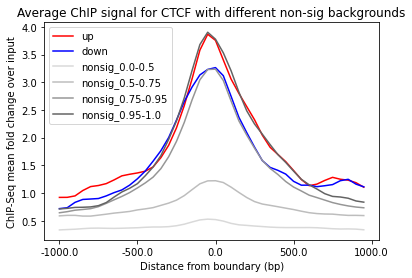

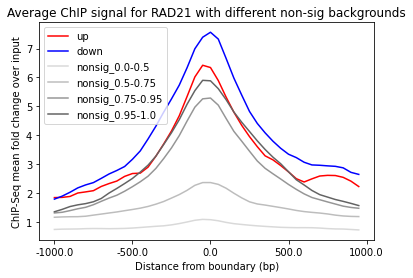

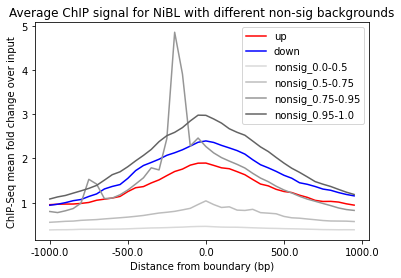

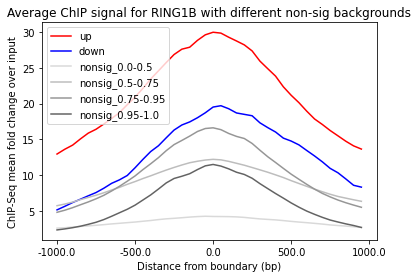

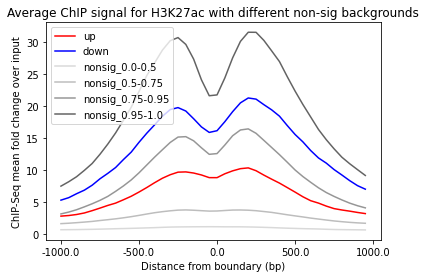

In [17]:
# Plot for all categories
for cond, chip_file in chip_seq_condition_dict.items():

    matrix = chip_seq_condition_matrix_dict[cond]
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    'Average ChIP signal for {} with different non-sig backgrounds'.format(cond), 
                    ax=None, 
                    category_colors=category_colormap,
                    DE_value_col='log2Fold_Change',
                    agg_key='DE_status', 
                    
                    window_size=1000, 
                    nbins=40)
    
    plt.show()
